In [1]:
# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, AncillaRegister, transpile, Aer
from qiskit.tools.jupyter import *
from qiskit.visualization import *
import matplotlib as mpl

from qiskit_aer import AerSimulator

from qiskit_ibm_runtime import QiskitRuntimeService, Sampler, Estimator, Session, Options

# Loading your IBM Quantum account(s)
service = QiskitRuntimeService(channel="ibm_quantum", token="c463eb3a1524dd933346849aed0b3d884b3ddc61eb9b51bb3d5e72fc187dc2000f09df38138222cde9284c2aea7a3b3a3d2694a96ef869e88ceccb898dd0b747")

/usr/local/lib/python3.10/dist-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


/usr/local/lib/python3.10/dist-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


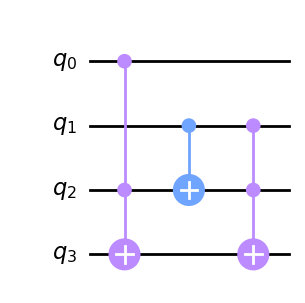

In [2]:
#creating the 4-qubit carry circuit and reverse circuit for carrying operations for the adder

carry_circuit = QuantumCircuit(4, name = "CARRY")
carry_circuit.ccx(1,2,3)
carry_circuit.cx(1,2)
carry_circuit.ccx(0,2,3)
carry_gate = carry_circuit.to_gate()

reverse_carry_circuit = carry_circuit.inverse()
reverse_carry_gate = reverse_carry_circuit.to_gate()

#carry_circuit.draw("mpl")
reverse_carry_circuit.draw("mpl")

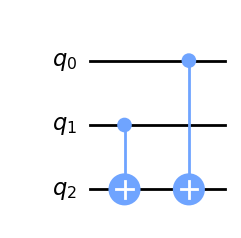

In [3]:
#creating the 3-qubit sum circuit for summing the bits and storing bitwise outputs for adder

sum_circuit = QuantumCircuit(3, name = "SUM")
sum_circuit.cx(1,2)
sum_circuit.cx(0,2)
sum_gate = sum_circuit.to_gate()

sum_circuit.draw("mpl")

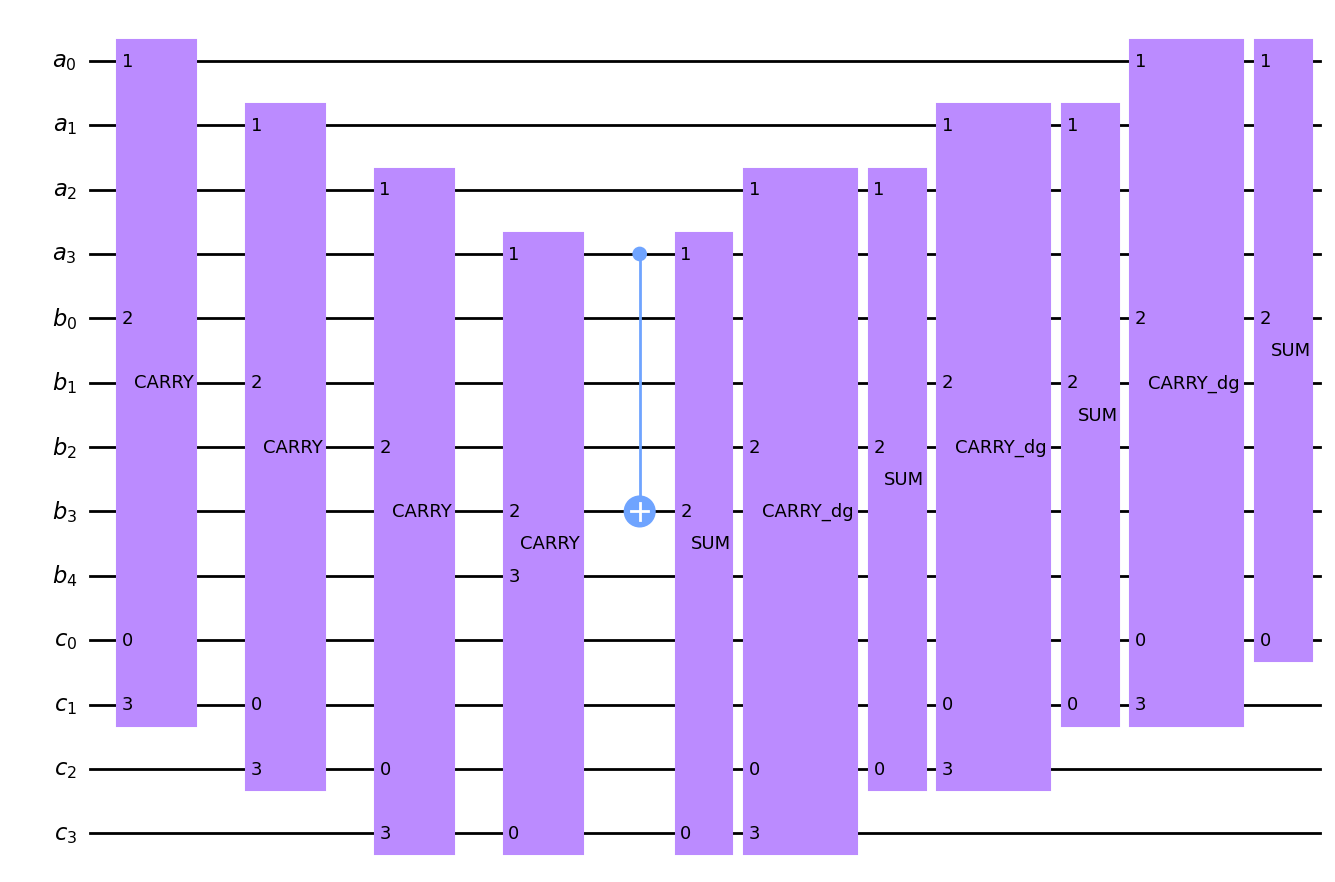

In [4]:
#creating the plain adder circuit with three quantum registers
#here qr_a is the register for the first value a, with n qubits
#qr_b is the register for the second value b, with n+1 qubits, and it stores the value a+b in the end
#qr_c is the ancilla register for storing carries, and has n-1 qubits

#temporary: a,b are our values, encoded in n bits

def padding(string, n):
    l = n - len(string)
    if l != 0:
        pad = ['0' for i in range(l)]
        return ''.join(pad) + string
    return string


def bin_string(val):
    string = str(bin(val))
    return string[2:]

qr_a = QuantumRegister(4, name='a')
qr_b = QuantumRegister(5, name='b')
qr_c = QuantumRegister(4, name='c')

#adder_circuit = QuantumCircuit(qr_a, qr_b, qr_c, cr, name = "ADDER")

adder_circuit = QuantumCircuit(qr_a, qr_b, qr_c, name = "ADDER")
    
n = qr_a.size
    
for i in range(1,n):
    adder_circuit.append(carry_gate, [qr_c[i-1], qr_a[i-1], qr_b[i-1], qr_c[i]])
    
adder_circuit.append(carry_gate, [qr_c[n-1], qr_a[n-1], qr_b[n-1], qr_b[n]])

adder_circuit.cx(qr_a[n-1], qr_b[n-1])

for i in range(n-1, 0, -1):
    adder_circuit.append(sum_gate, [qr_c[i], qr_a[i], qr_b[i]])
    adder_circuit.append(reverse_carry_gate, [qr_c[i-1], qr_a[i-1], qr_b[i-1], qr_c[i]])
    
adder_circuit.append(sum_gate, [qr_c[0], qr_a[0], qr_b[0]])

reverse_adder_circuit = adder_circuit.inverse()

#adder_circuit.measure(qr_b, cr)

adder_gate = adder_circuit.to_gate()

reverse_adder_gate = reverse_adder_circuit.to_gate()

adder_circuit.draw('mpl')



In [5]:
"""
simulator = AerSimulator()
compiled_circuit = transpile(adder_circuit, simulator)
job = simulator.run(compiled_circuit, shots=10)
result = job.result()
counts = result.get_counts(compiled_circuit)
plot_histogram(counts)
"""

'\nsimulator = AerSimulator()\ncompiled_circuit = transpile(adder_circuit, simulator)\njob = simulator.run(compiled_circuit, shots=10)\nresult = job.result()\ncounts = result.get_counts(compiled_circuit)\nplot_histogram(counts)\n'

/usr/local/lib/python3.10/dist-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


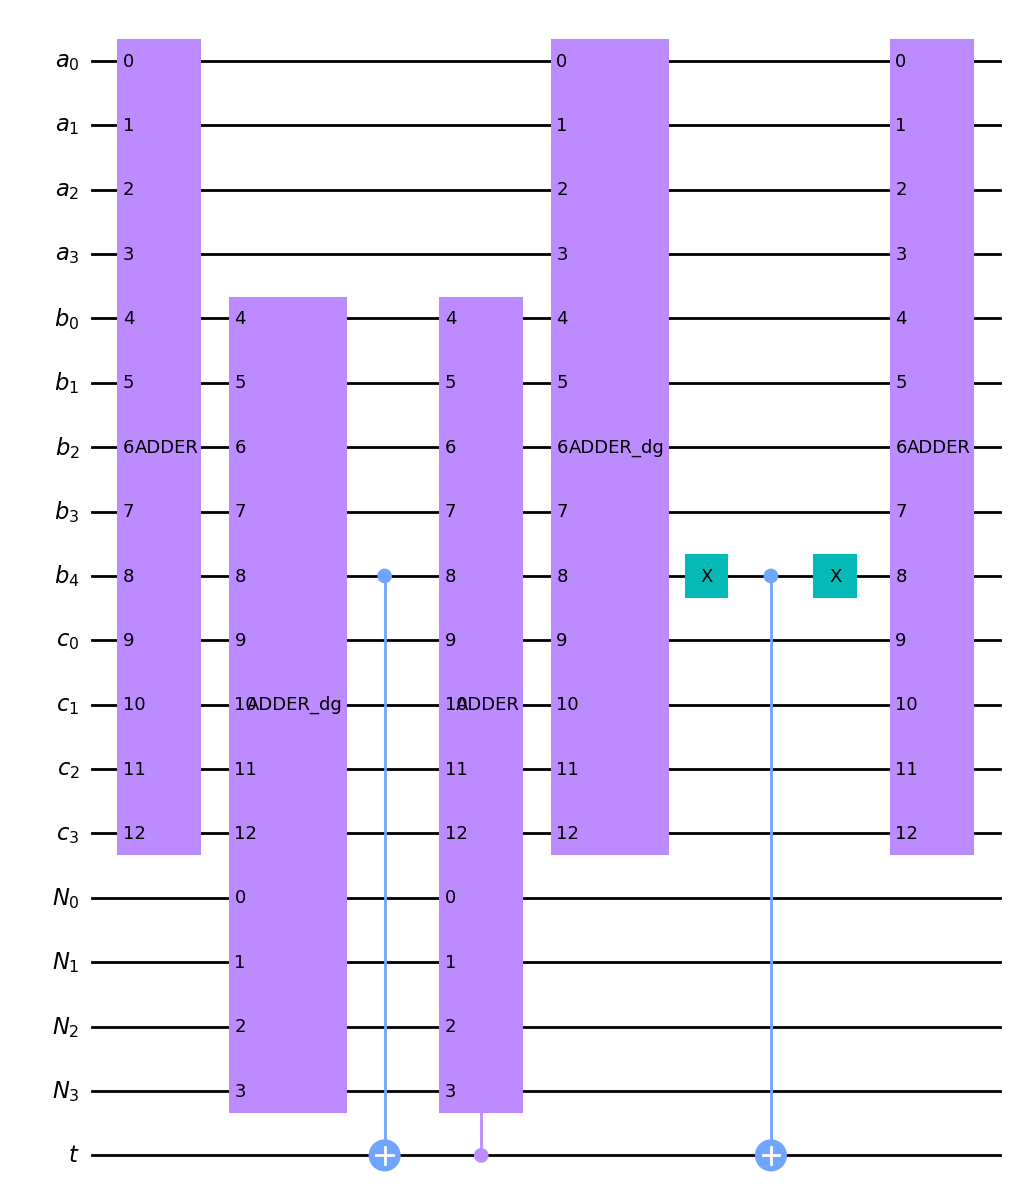

In [31]:
#creating the adder mod circuit with 4 quantum registers
#we want to compute a+b modulo N
#here a,b<=N, and all are encoded in bits
#qr_a and qr_b correspond to registers for a,b, and qr_N corresponds to N
#while qr_0 is a single qubit register initialised to state 0
#we also keep an ancilla register of size n-1, called qr_c for carries in the adder
#qr_a qr_N are n qubit, qr_b is n+1 qubit and qr_c is n-1 qubit

qr_N = QuantumRegister(4, name = "N")
qr_0 = QuantumRegister(1, name = "t")
#cr = ClassicalRegister(1, name= 'cr')

'''
a = 2
b = 4
N = 13


string_a = padding(bin_string(a), n)
print("a is "+string_a)

string_b = padding(bin_string(b), n+1)
print("b is "+string_b)

string_N = bin_string(N)
print("N is "+string_N)
'''

adder_mod_circuit = QuantumCircuit(qr_a, qr_b, qr_c, qr_N, qr_0, name = "ADDER MOD")

n = qr_a.size

'''
#loading register with value N

for i in range(n):
    if string_N[i]=='1':
        adder_mod_circuit.x(qr_N[n-i-1]) 
        
#loading registers with values a,b

for i in range(n):
    if string_a[i]=='1':
        adder_mod_circuit.x(qr_a[n-i-1])
        
for i in range(n+1):
    if string_b[i]=='1':
        adder_mod_circuit.x(qr_b[n-i])
'''        

list_a = [qr_a[i] for i in range(n)]
list_b = [qr_b[i] for i in range(n+1)]
list_c = [qr_c[i] for i in range(n)]

adder_mod_circuit.append(adder_gate, list_a+list_b+list_c)

list_N = [qr_N[i] for i in range(n)]

adder_mod_circuit.append(reverse_adder_gate, list_N+list_b+list_c)

#adder_mod_circuit.x(qr_b[n])

adder_mod_circuit.cx(qr_b[n], qr_0[0])

#adder_mod_circuit.measure(qr_b, cr)


#adder_mod_circuit.x(qr_b[n])

#making controlled adder gate
c_adder = adder_gate.control()

adder_mod_circuit.append(c_adder, [qr_0[0]]+list_N+list_b+list_c)

adder_mod_circuit.append(reverse_adder_gate, list_a+list_b+list_c)

adder_mod_circuit.x(qr_b[n])

adder_mod_circuit.cx(qr_b[n], qr_0[0])

adder_mod_circuit.x(qr_b[n])

adder_mod_circuit.append(adder_gate, list_a+list_b+list_c)

#adder_mod_circuit.measure(qr_0, cr)

adder_mod_gate = adder_mod_circuit.to_gate()

adder_mod_circuit.draw("mpl")

In [32]:
'''
simulator = AerSimulator()
compiled_circuit = transpile(adder_mod_circuit, simulator)
job = simulator.run(compiled_circuit, shots=10)
result = job.result()
counts = result.get_counts(compiled_circuit)
plot_histogram(counts)
'''

'\nsimulator = AerSimulator()\ncompiled_circuit = transpile(adder_mod_circuit, simulator)\njob = simulator.run(compiled_circuit, shots=10)\nresult = job.result()\ncounts = result.get_counts(compiled_circuit)\nplot_histogram(counts)\n'

a is 1010
N is 1110
x is 1001
1010
0110
1100
1010


/usr/local/lib/python3.10/dist-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


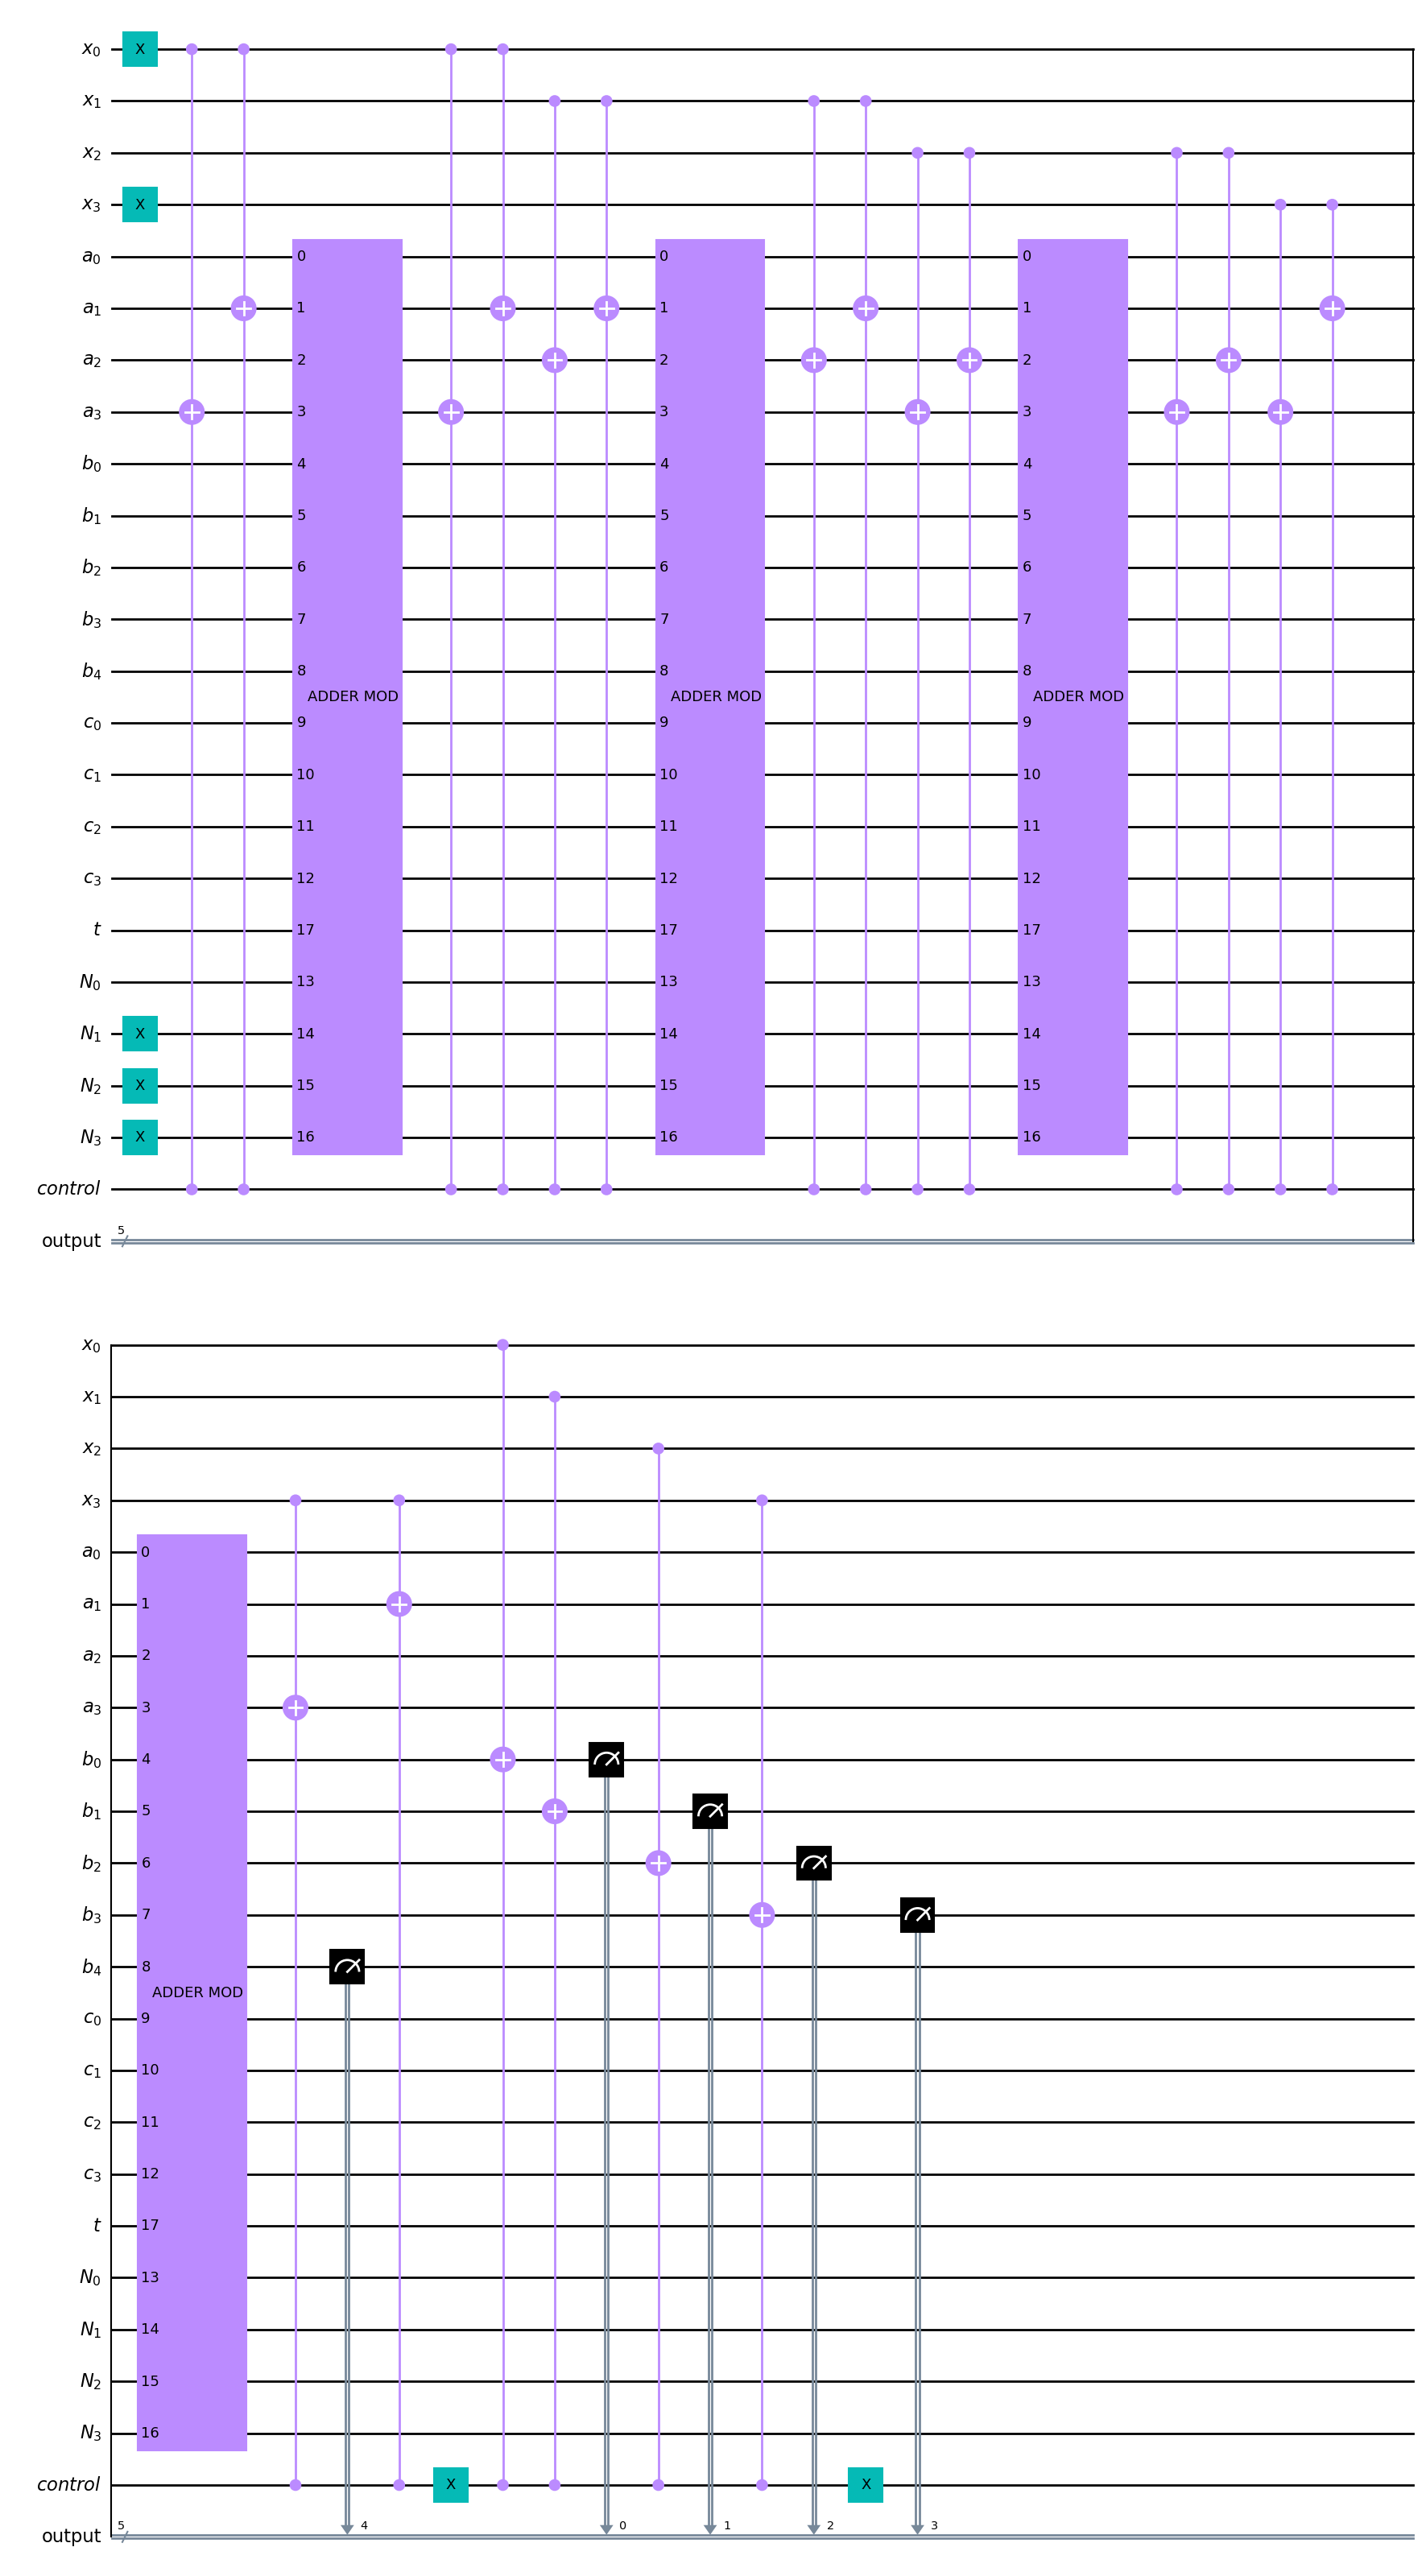

In [45]:
#controlled multiplication circuit

def mult_comp(a, i, N):
    string = str(bin((a*(2**i)) % N))
    return string[2:]


qr_x = QuantumRegister(4, name='x')
c = QuantumRegister(1, name='control')
cr = ClassicalRegister(5, name = 'output')    

#qr_v = QuantumRegister(4, name='v')

#list_v = [qr_v[i] for i in range(n+1)]

N = 14
a = 10
x = 9
#b = 4

n = qr_a.size

string_a = padding(bin_string(a), n)
print("a is "+string_a)

#string_b = padding(bin_string(b), n+1)
#print("b is "+string_b)

string_N = bin_string(N)
print("N is "+string_N)

string_x = padding(bin_string(x), n)
print("x is "+string_x)

CMult_circuit = QuantumCircuit(qr_x, qr_a, qr_b, qr_c, qr_0, qr_N, cr, c, name = "Ctrl MULT MOD")   
#cr is our classical register
#CMult_circuit.x(c)  #control bit set to 1

#loading register with value N

for i in range(n):
    if string_N[i]=='1':
        CMult_circuit.x(qr_N[n-i-1]) 

#loading register with value x

for i in range(n):
    if string_x[i]=='1':
        CMult_circuit.x(qr_x[n-i-1])
        
#main circuit: loading values a*2^i iteratively and adding the adder mod gates

"""
for i in range(n):
    bl = mult_comp(a, i, N)
    l = padding(bl, n)
    print(l)
    for j in range(n):
        if(l[j]=='1'):
            CMult_circuit.ccx(qr_x[i], c[0], qr_a[n-j-1])
    list_a = [qr_a[i] for i in range(n)]
    list_b = [qr_b[i] for i in range(n+1)]
    CMult_circuit.append(adder_mod_gate, list_a+list_b+list_c+list_N+[qr_0[0]])
    for j in range(n):                                         #toffoli inversion
        if(l[j]=='1'):
            CMult_circuit.ccx(qr_x[i], c[0], qr_a[n-j-1])
"""


for i in range(n):
    bl = mult_comp(a, i, N)
    l = padding(bl, n)
    print(l)
    for j in range(n):
        if(l[j]=='1'):
            CMult_circuit.ccx(qr_x[i], c, qr_a[n-j-1])
            
    CMult_circuit.append(adder_mod_gate, list_a+list_b+list_c+list_N+[qr_0[0]])
     
    for j in range(n):                                         #toffoli inversion
        if(l[j]=='1'):
            CMult_circuit.ccx(qr_x[i], c, qr_a[n-j-1])
            

CMult_circuit.x(c)

for i in range(n):
    CMult_circuit.ccx(c, qr_x[i],qr_b[i])
    
CMult_circuit.x(c)

CMult_circuit.measure(qr_b, cr)

CMult_circuit.draw("mpl")


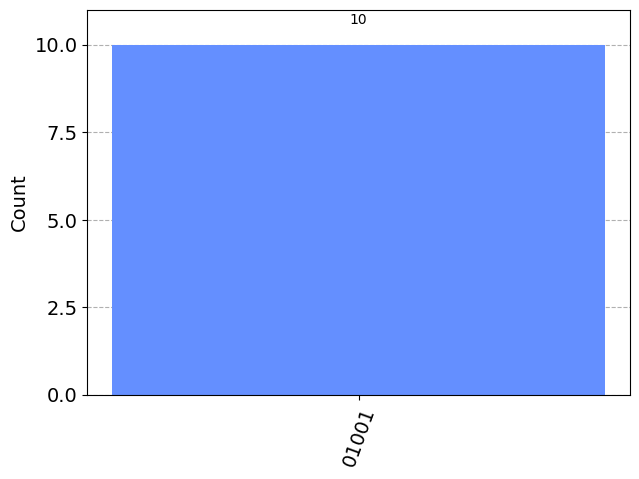

In [46]:
simulator = AerSimulator()
compiled_circuit = transpile(CMult_circuit, simulator)
job = simulator.run(compiled_circuit, shots=10)
result = job.result()
counts = result.get_counts(compiled_circuit)
plot_histogram(counts)


In [10]:
#circuit for modular exponentiation


    
         
    
    
    

        
    
    